In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import codecs
import json

from sklearn.model_selection import train_test_split
from nltk import sent_tokenize, word_tokenize

from data_preparation.EMA_documents import SectionLeaflet, Leaflet

In [17]:
# load array of objects, where object - class Leaflet
with open("LeafletsDataset_section1_NER_outputs.dat", "rb") as f:
    loaded_package_leaflets = pickle.load(f)

In [18]:
len(loaded_package_leaflets)

1250

### Clean dataset

In [19]:
loaded_package_leaflets[0].section1.section_content

'trydonis is a medicine to help breathing that contains the three active substances: beclometasone dipropionate, formoterol fumarate dihydrate and glycopyrronium. beclometasone dipropionate belongs to a group of medicines called corticosteroids which act to reduce the swelling and irritation in your lungs. formoterol and glycopyrronium are medicines called longacting bronchodilators. they act in different ways to relax the muscles in your airways, helping to open the airways wider and allowing you to breathe more easily. regular treatment with these three active substances helps to relieve and prevent symptoms such as shortness of breath, wheezing and cough in adult patients with chronic obstructive pulmonary disease (copd). trydonis can reduce exacerbations (flareups) of copd symptoms. copd is a serious long term disease in which the airways become blocked and air sacs inside the lungs become damaged, leading to difficulty breathing.'

In [20]:
leaflets_length = []

for leaflet in loaded_package_leaflets:
    section1_content = leaflet.section1.section_content
    
    # remove None or empty section content
    if section1_content is None or len(section1_content) == 0:
        # loaded_package_leaflets.remove(leaflet)
        print(section1_content)
    
    # calc the length of section1 content and add to list
    leaflets_length.append(len(section1_content))

In [21]:
len(loaded_package_leaflets)

1250

In [22]:
np.mean(leaflets_length)

1070.3224

(array([324., 570., 213.,  74.,  30.,  19.,   4.,   4.,   0.,   1.,   4.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   65.        ,   613.13333333,  1161.26666667,  1709.4       ,
         2257.53333333,  2805.66666667,  3353.8       ,  3901.93333333,
         4450.06666667,  4998.2       ,  5546.33333333,  6094.46666667,
         6642.6       ,  7190.73333333,  7738.86666667,  8287.        ,
         8835.13333333,  9383.26666667,  9931.4       , 10479.53333333,
        11027.66666667, 11575.8       , 12123.93333333, 12672.06666667,
        13220.2       , 13768.33333333, 14316.46666667, 14864.6       ,
        15412.73333333, 15960.86666667, 16509.        ]),
 <a list of 30 Patch objects>)

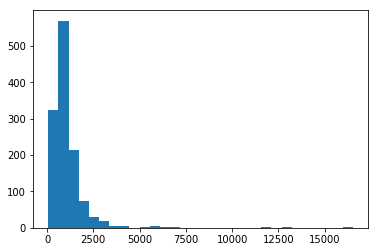

In [23]:
plt.hist(leaflets_length, bins=30)

In [25]:
# remove "outliers" - just make a better content extraction system! 

count_large_content = 0

for leaflet in loaded_package_leaflets:
    section1_content = leaflet.section1.section_content
    
    if len(section1_content) >= 3000:
        count_large_content += 1
        loaded_package_leaflets.remove(leaflet)

print(count_large_content)

1


In [26]:
leaflets_length = []

for leaflet in loaded_package_leaflets:
    leaflets_length.append(len(leaflet.section1.section_content))

In [27]:
len(loaded_package_leaflets)

1220

In [28]:
np.mean(leaflets_length)

961.7909836065573

(array([ 1.,  0.,  0.,  2.,  3.,  4.,  4., 12., 16., 16., 25., 23., 29.,
        29., 30., 33., 36., 40., 28., 36., 40., 38., 37., 32., 59., 32.,
        21., 36., 36., 29., 26., 29., 23., 21., 22., 26., 15., 19., 26.,
        18., 21., 10.,  9., 11.,  8., 11.,  7., 11., 13.,  4., 12.,  8.,
         9.,  5.,  8.,  6.,  8.,  5.,  2.,  2.,  3.,  6.,  7., 11.,  2.,
         4.,  5.,  3.,  3.,  4.,  5.,  2.,  1.,  1.,  2.,  0.,  1.,  1.,
         2.,  2.,  3.,  2.,  0.,  4.,  1.,  1.,  1.,  1.,  4.,  2.,  2.,
         1.,  2.,  2.,  3.,  0.,  1.,  1.,  0.,  2.]),
 array([  65.  ,   94.29,  123.58,  152.87,  182.16,  211.45,  240.74,
         270.03,  299.32,  328.61,  357.9 ,  387.19,  416.48,  445.77,
         475.06,  504.35,  533.64,  562.93,  592.22,  621.51,  650.8 ,
         680.09,  709.38,  738.67,  767.96,  797.25,  826.54,  855.83,
         885.12,  914.41,  943.7 ,  972.99, 1002.28, 1031.57, 1060.86,
        1090.15, 1119.44, 1148.73, 1178.02, 1207.31, 1236.6 , 1265.89,
        

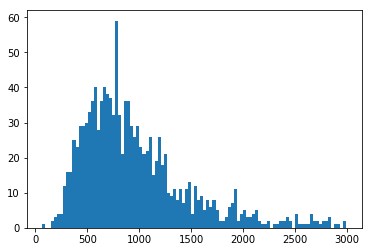

In [29]:
plt.hist(leaflets_length, bins=100)

In [30]:
# split dataset into train-valid-test (1000-120-100) and shuffle 

# train - test
train_leaflets, test_leaflets = train_test_split(loaded_package_leaflets, test_size=100, random_state=42, shuffle=True)

# train - valid 
train_leaflets, valid_leaflets = train_test_split(train_leaflets, test_size=120, random_state=42, shuffle=True)

## Produce same output as the script *create_dataset* from data2text-plain

### Plan

section_content -------- true text   

entity_recognition  ------- actually input - set of records   

Set of records in order they appear in section_content    -------- content plan 

In [31]:
RECORD_DELIM = " "
DELIM = u"￨"

HOMEAWAY = "HOME"
ENTITY = "Indication"

PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
UNK = 0
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [32]:
summaries_leaflets = []
src_leaflets = []
content_plan_leaflets = []

In [33]:
# Transform training data to be a suitable format for model data2text-plan

for leaflet in train_leaflets:
    section1_content = leaflet.section1.section_content
    section1_entity_recognition = leaflet.section1.entity_recognition
    
    # get content plan
    content_plan_section1 = ''
    
    for entity in section1_entity_recognition:
        entity_value = entity['Text'] if len(entity['Text'].split(" ")) == 0 else ("_").join(entity['Text'].split(" "))
        entity_type = entity['Type'] if entity['Type'] is not None and len(entity['Type']) > 0 else entity['Category']
        
        content_plan_section1 += entity_value + DELIM + ENTITY + DELIM + entity_type + DELIM + HOMEAWAY
        
        if section1_entity_recognition.index(entity) != len(section1_entity_recognition) - 1:
            content_plan_section1 += " "
        else:
            content_plan_section1 += " " + "\n"
        
    
    content_plan_leaflets.append(content_plan_section1)
    
    # get the section1 content
    section1_content = section1_content + "\n"
    summaries_leaflets.append(section1_content)
    

In [34]:
def add_special_records(records):
    record = []
    record.append(UNK_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    records.append(DELIM.join(record))
    record = []
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    records.append(DELIM.join(record))
    record = []
    record.append(BOS_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    records.append(DELIM.join(record))
    record = []
    record.append(EOS_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    record.append(PAD_WORD)
    records.append(DELIM.join(record))
    
    return records

In [35]:
# get the src_train - training data to be input to the model

for leaflet_content_plan in content_plan_leaflets:
    # remove the end symbol ('n') of the string
    leaflet_content_plan = leaflet_content_plan[:-2]
    
    # spli string into a list of records
    leaflet_content_plan_collection = leaflet_content_plan.split(" ")
    
    # randomly shuffle records in a list
    random.shuffle(leaflet_content_plan_collection)
    
    # add special symbols to the begining
    special_symbols = []
    special_symbols = add_special_records(special_symbols)
    
    # create a string containing all the records and special_symbols in the begining
    src_leaflet_section1 = ''
    
    src_leaflet_section1 += " ".join(special_symbols)
    src_leaflet_section1 += " "
    
    src_leaflet_section1 += " ".join(leaflet_content_plan_collection)
    src_leaflet_section1 += '\n'
    
    
    src_leaflets.append(src_leaflet_section1)

In [36]:
len(src_leaflets)

1000

In [37]:
len(content_plan_leaflets)

1000

In [38]:
len(summaries_leaflets)

1000

In [55]:
src_leaflets[1]

'<unk>￨<blank>￨<blank>￨<blank> <blank>￨<blank>￨<blank>￨<blank> <s>￨<blank>￨<blank>￨<blank> </s>￨<blank>￨<blank>￨<blank> atazanavir￨Indication￨GENERIC_NAME￨HOME infection￨Indication￨DX_NAME￨HOME protease_inhibitors￨Indication￨TREATMENT_NAME￨HOME illnesses￨Indication￨DX_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME evotaz￨Indication￨BRAND_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME immunodeficiency_syndrome￨Indication￨DX_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME cobicistat￨Indication￨GENERIC_NAME￨HOME evotaz￨Indication￨BRAND_NAME￨HOME 18￨Indication￨AGE￨HOME human_immunodeficiency_virus￨Indication￨DX_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME infected￨Indication￨DX_NAME￨HOME evotaz￨Indication￨BRAND_NAME￨HOME hiv_infection￨Indication￨DX_NAME￨HOME cobicistat￨Indication￨GENERIC_NAME￨HOME hiv_infection￨Indication￨DX_NAME￨HOME immune_system￨Indication￨SYSTEM_

In [31]:
content_plan_leaflets[1]

'evotaz￨Indication￨BRAND_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME protease_inhibitors￨Indication￨TREATMENT_NAME￨HOME human_immunodeficiency_virus￨Indication￨DX_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME infection￨Indication￨DX_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME immune_system￨Indication￨SYSTEM_ORGAN_SITE￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME illnesses￨Indication￨DX_NAME￨HOME hiv_infection￨Indication￨DX_NAME￨HOME cobicistat￨Indication￨GENERIC_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME cobicistat￨Indication￨GENERIC_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME evotaz￨Indication￨BRAND_NAME￨HOME 18￨Indication￨AGE￨HOME infected￨Indication￨DX_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME immunodeficiency_syndrome￨Indication￨DX_NAME￨HOME hiv_infection￨Indication￨DX_NAME￨HOME evotaz￨Indication￨BRAND_NAME￨HOME \n'

In [32]:
summaries_leaflets[1]

'evotaz contains two active substances: \uf0a7 atazanavir, an antiviral (or antiretroviral) medicine. it is one of a group called protease inhibitors. these medicines control human immunodeficiency virus (hiv) infection by stopping production of a protein that hiv needs for its multiplication. they work by reducing the amount of hiv in your body and this in turn, strengthens your immune system. in this way atazanavir reduces the risk of developing illnesses linked to hiv infection. \uf0a7 cobicistat, a booster (pharmacokinetic enhancer) to help improve the effects of atazanavir. cobicistat, does not directly treat your hiv, but boosts the levels of atazanavir in the blood. it does this by slowing down the breakdown of atazanavir which will make it stay in the body for longer. evotaz may be used by adults aged 18 years of age and older who are infected with hiv, the virus that causes acquired immunodeficiency syndrome (aids). it is used in combination with other antihiv medicines to hel

In [33]:
# Output files

INTER_CONTENT_PLAN = 'inter/train_content_plan.txt'  # intermediate content plan input to second stage
SRC_FILE = 'src_train.txt'  # src file input to first stage
TRAIN_TGT_FILE = "tgt_train.txt"  # tgt file of second stage
CONTENT_PLAN_OUT = 'train_content_plan.txt'  # content plan output of first stage

In [34]:
output_file = open(INTER_CONTENT_PLAN, 'w')
for content_plan in content_plan_leaflets:
    output_file.write(content_plan) #.encode("utf-8"))
    # output_file.write('\n')
output_file.close()

In [35]:
summary_file = open(TRAIN_TGT_FILE, 'w')
for summary_leaflet in summaries_leaflets:
    # summary = [word.encode("utf-8") for word in summary_leaflet.split()]
    # summary_file.write(" ".join(summary))
    summary_file.write(summary_leaflet)
    # summary_file.write("\n")
summary_file.close()

In [36]:
src_file = open(SRC_FILE, 'w')
for src_instance in src_leaflets:
    # src_file.write(src_instance.encode("utf-8"))
    src_file.write(src_instance)
    # src_file.write("\n")
src_file.close()

### Finally, the last file needed - *rotowire/train_content_plan.txt*

In [37]:
# read files with training data and content plan

inputs = []
content_plans = []
with codecs.open(INTER_CONTENT_PLAN, "r", "utf-8") as corpus_file:
    for i, line in enumerate(corpus_file):
        content_plans.append(line.split())

with codecs.open(SRC_FILE, "r", "utf-8") as corpus_file:
    for i, line in enumerate(corpus_file):
        inputs.append(line.split())

In [38]:
len(inputs)

1000

In [39]:
len(content_plans)

1000

In [40]:
# basically - now content plan POINTs to index in the training dataset
# content_plan - collection of indexes where each index points to record in training dataset - training_dataset[index]

outputs = []

for i, training_sample in enumerate(inputs):
    
    content_plan = content_plans[i]
    output = []
    
    for record in content_plan:
        output.append(str(training_sample.index(record)))
        
    outputs.append(" ".join(output))

In [41]:
outputs[5]

'4 18 7 26 4 28 10 14 24 4 4 29 27 13 4 13 7 5 30 32 13 7 5 9 31 17 22 12 6'

In [42]:
# write to a file

output_file = open(CONTENT_PLAN_OUT, 'w')

# add \n to the end of the string
output_file.write("\n".join(outputs))
# add \n between content plans
output_file.write("\n")

output_file.close()

## Check the *leaflets* training input files and *NBA* input files

In [40]:
with open('rotowire/inter/train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_inter_train_content_plan = reader.readlines()

In [41]:
with open('inter/train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_inter_train_content_plan = reader.readlines()

FileNotFoundError: [Errno 2] No such file or directory: 'inter/train_content_plan.txt'

In [42]:
nba_inter_train_content_plan[22]

'Atlanta￨Hawks￨TEAM-CITY￨HOME Hawks￨Hawks￨TEAM-NAME￨HOME 36￨Hawks￨TEAM-WINS￨HOME 8￨Hawks￨TEAM-LOSSES￨HOME 103￨Hawks￨TEAM-PTS￨HOME 48￨Hawks￨TEAM-FG_PCT￨HOME Paul￨Paul_Millsap￨FIRST_NAME￨HOME Millsap￨Paul_Millsap￨SECOND_NAME￨HOME 22￨Paul_Millsap￨PTS￨HOME 10￨Paul_Millsap￨REB￨HOME Al￨Al_Horford￨FIRST_NAME￨HOME Horford￨Al_Horford￨SECOND_NAME￨HOME 14￨Al_Horford￨PTS￨HOME 12￨Al_Horford￨REB￨HOME Jeff￨Jeff_Teague￨FIRST_NAME￨HOME Teague￨Jeff_Teague￨SECOND_NAME￨HOME 17￨Jeff_Teague￨PTS￨HOME 9￨Jeff_Teague￨AST￨HOME DeMarre￨DeMarre_Carroll￨FIRST_NAME￨HOME Carroll￨DeMarre_Carroll￨SECOND_NAME￨HOME 13￨DeMarre_Carroll￨PTS￨HOME Dennis￨Dennis_Schroder￨FIRST_NAME￨HOME Schroder￨Dennis_Schroder￨SECOND_NAME￨HOME 13￨Dennis_Schroder￨PTS￨HOME 27￨Hawks￨TEAM-AST￨HOME Russell￨Russell_Westbrook￨FIRST_NAME￨AWAY Westbrook￨Russell_Westbrook￨SECOND_NAME￨AWAY 22￨Russell_Westbrook￨PTS￨AWAY Kevin￨Kevin_Durant￨FIRST_NAME￨AWAY Durant￨Kevin_Durant￨SECOND_NAME￨AWAY 21￨Kevin_Durant￨PTS￨AWAY Serge￨Serge_Ibaka￨FIRST_NAME￨AWAY Ibaka

In [48]:
leaflet_inter_train_content_plan[22]

'bimatoprost￨Indication￨GENERIC_NAME￨HOME timolol￨Indication￨GENERIC_NAME￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨HOME bimatoprost￨Indication￨GENERIC_NAME￨HOME prostaglandin￨Indication￨GENERIC_NAME￨HOME timolol￨Indication￨GENERIC_NAME￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨HOME glaucoma￨Indication￨DX_NAME￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨HOME glaucoma￨Indication￨DX_NAME￨HOME eye￨Indication￨SYSTEM_ORGAN_SITE￨HOME eye_drops￨Indication￨TREATMENT_NAME￨HOME prostaglandin_analogues￨Indication￨GENERIC_NAME￨HOME \n'

In [49]:
len(leaflet_inter_train_content_plan)

1000

In [47]:
with open('rotowire/src_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_src_train = reader.readlines()

In [51]:
with open('src_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_src_train = reader.readlines()

In [50]:
nba_src_train[45]

'<unk>￨<blank>￨<blank>￨<blank> <blank>￨<blank>￨<blank>￨<blank> <s>￨<blank>￨<blank>￨<blank> </s>￨<blank>￨<blank>￨<blank> F￨Wilson_Chandler￨START_POSITION￨HOME 28￨Wilson_Chandler￨MIN￨HOME 9￨Wilson_Chandler￨PTS￨HOME 2￨Wilson_Chandler￨FGM￨HOME 7￨Wilson_Chandler￨FGA￨HOME 29￨Wilson_Chandler￨FG_PCT￨HOME 0￨Wilson_Chandler￨FG3M￨HOME 0￨Wilson_Chandler￨FG3A￨HOME 0￨Wilson_Chandler￨FG3_PCT￨HOME 5￨Wilson_Chandler￨FTM￨HOME 8￨Wilson_Chandler￨FTA￨HOME 63￨Wilson_Chandler￨FT_PCT￨HOME 2￨Wilson_Chandler￨OREB￨HOME 6￨Wilson_Chandler￨DREB￨HOME 8￨Wilson_Chandler￨REB￨HOME 3￨Wilson_Chandler￨AST￨HOME 0￨Wilson_Chandler￨TO￨HOME 0￨Wilson_Chandler￨STL￨HOME 0￨Wilson_Chandler￨BLK￨HOME 1￨Wilson_Chandler￨PF￨HOME Wilson￨Wilson_Chandler￨FIRST_NAME￨HOME Chandler￨Wilson_Chandler￨SECOND_NAME￨HOME F￨Danilo_Gallinari￨START_POSITION￨HOME 36￨Danilo_Gallinari￨MIN￨HOME 27￨Danilo_Gallinari￨PTS￨HOME 9￨Danilo_Gallinari￨FGM￨HOME 19￨Danilo_Gallinari￨FGA￨HOME 47￨Danilo_Gallinari￨FG_PCT￨HOME 7￨Danilo_Gallinari￨FG3M￨HOME 14￨Danilo_Gallinar

In [57]:
leaflet_src_train[45]

'<unk>￨<blank>￨<blank>￨<blank> <blank>￨<blank>￨<blank>￨<blank> <s>￨<blank>￨<blank>￨<blank> </s>￨<blank>￨<blank>￨<blank> tadalafil￨Indication￨GENERIC_NAME￨HOME lungs￨Indication￨SYSTEM_ORGAN_SITE￨HOME phosphodiesterase_type_5_(pde5)_inhibitors￨Indication￨TREATMENT_NAME￨HOME adcirca￨Indication￨BRAND_NAME￨HOME pulmonary_arterial_hypertension￨Indication￨DX_NAME￨HOME adcirca￨Indication￨BRAND_NAME￨HOME lungs￨Indication￨SYSTEM_ORGAN_SITE￨HOME\n'

In [58]:
with open('rotowire/tgt_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_tgt_train = reader.readlines()

In [59]:
with open('tgt_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_tgt_train = reader.readlines()

In [62]:
leaflet_tgt_train[21]

'Pemetrexed Sandoz is a medicine used in the treatment of cancer. Pemetrexed Sandoz is given in combination with cisplatin, another anti-cancer medicine, as treatment for malignant pleural mesothelioma, a form of cancer that affects the lining of the lung, to patients who have not received prior chemotherapy. Pemetrexed Sandoz is also given in combination with cisplatin for the initial treatment of patients with advanced stage of lung cancer. Pemetrexed Sandoz can be prescribed to you if you have lung cancer at an advanced stage if your disease has responded to treatment or it remains largely unchanged after initial chemotherapy. Pemetrexed Sandoz is also a treatment for patients with advanced stage of lung cancer whose disease has progressed after other initial chemotherapy has been used.\n'

In [63]:
nba_tgt_train[21]

"The Atlanta Hawks defeated the Miami Heat , 103 - 95 , at Philips Arena on Wednesday . Atlanta was in desperate need of a win and they were able to take care of a shorthanded Miami team here . Defense was key for the Hawks , as they held the Heat to 42 percent shooting and forced them to commit 16 turnovers . Atlanta also dominated in the paint , winning the rebounding battle , 47 - 34 , and outscoring them in the paint 58 - 26.The Hawks shot 49 percent from the field and assisted on 27 of their 43 made baskets . This was a near wire - to - wire win for the Hawks , as Miami held just one lead in the first five minutes . Miami ( 7 - 15 ) are as beat - up as anyone right now and it 's taking a toll on the heavily used starters . Hassan Whiteside really struggled in this game , as he amassed eight points , 12 rebounds and one blocks on 4 - of - 12 shooting . Tyler Johnson was the team 's best player , as he tallied 27 points and five assists off the bench . Goran Dragic continued his goo

==============================================================================================================================
## Validation dataset 

In [64]:
len(valid_leaflets)

120

In [65]:
summaries_leaflets_valid = []
src_leaflets_valid = []
content_plan_leaflets_valid = []

In [66]:
# Transform *validation* data to be a suitable format for model data2text-plan

for leaflet in valid_leaflets:
    section1_content = leaflet.section1.section_content
    section1_entity_recognition = leaflet.section1.entity_recognition
    
    # get content plan
    content_plan_section1 = ''
    
    for entity in section1_entity_recognition:
        entity_value = entity['Text'] if len(entity['Text'].split(" ")) == 0 else ("_").join(entity['Text'].split(" "))
        entity_type = entity['Type'] if entity['Type'] is not None and len(entity['Type']) > 0 else entity['Category']
        
        content_plan_section1 += entity_value + DELIM + ENTITY + DELIM + entity_type + DELIM + HOMEAWAY
        
        if section1_entity_recognition.index(entity) != len(section1_entity_recognition) - 1:
            content_plan_section1 += " "
        else:
            content_plan_section1 += " " + "\n"
        
    
    content_plan_leaflets_valid.append(content_plan_section1)
    
    # get the section1 content
    section1_content = section1_content + "\n"
    summaries_leaflets_valid.append(section1_content)

In [69]:
len(content_plan_leaflets_valid)

120

In [70]:
len(summaries_leaflets_valid)

120

In [71]:
# get the src_train - training data to be input to the model

for leaflet_content_plan in content_plan_leaflets_valid:
    # remove the end symbol ('n') of the string
    leaflet_content_plan = leaflet_content_plan[:-2]
    
    # spli string into a list of records
    leaflet_content_plan_collection = leaflet_content_plan.split(" ")
    
    # randomly shuffle records in a list
    random.shuffle(leaflet_content_plan_collection)
    
    # add special symbols to the begining
    special_symbols = []
    special_symbols = add_special_records(special_symbols)
    
    # create a string containing all the records and special_symbols in the begining
    src_leaflet_section1 = ''
    
    src_leaflet_section1 += " ".join(special_symbols)
    src_leaflet_section1 += " "
    
    src_leaflet_section1 += " ".join(leaflet_content_plan_collection)
    src_leaflet_section1 += '\n'
    
    
    src_leaflets_valid.append(src_leaflet_section1)

In [72]:
len(src_leaflets_valid)

120

In [73]:
# Output files

INTER_CONTENT_PLAN_VALID = 'inter/valid_content_plan.txt'  # intermediate content plan input to second stage
SRC_FILE_VALID = 'src_valid.txt'  # src file input to first stage
TRAIN_TGT_FILE_VALID = "tgt_valid.txt"  # tgt file of second stage
CONTENT_PLAN_OUT_VALID = 'valid_content_plan.txt'  # content plan output of first stage

In [74]:
output_file = open(INTER_CONTENT_PLAN_VALID, 'w')
for content_plan in content_plan_leaflets_valid:
    output_file.write(content_plan) #.encode("utf-8"))
    # output_file.write('\n')
output_file.close()

In [75]:
summary_file = open(TRAIN_TGT_FILE_VALID, 'w')
for summary_leaflet in summaries_leaflets_valid:
    # summary = [word.encode("utf-8") for word in summary_leaflet.split()]
    # summary_file.write(" ".join(summary))
    summary_file.write(summary_leaflet)
    # summary_file.write("\n")
summary_file.close()

In [76]:
src_file = open(SRC_FILE_VALID, 'w')
for src_instance in src_leaflets_valid:
    # src_file.write(src_instance.encode("utf-8"))
    src_file.write(src_instance)
    # src_file.write("\n")
src_file.close()

In [77]:
# read files with training data and content plan

inputs = []
content_plans = []
with codecs.open(INTER_CONTENT_PLAN_VALID, "r", "utf-8") as corpus_file:
    for i, line in enumerate(corpus_file):
        content_plans.append(line.split())

with codecs.open(SRC_FILE_VALID, "r", "utf-8") as corpus_file:
    for i, line in enumerate(corpus_file):
        inputs.append(line.split())

In [78]:
# basically - now content plan POINTs to index in the training dataset
# content_plan - collection of indexes where each index points to record in training dataset - training_dataset[index]

outputs = []

for i, training_sample in enumerate(inputs):
    
    content_plan = content_plans[i]
    output = []
    
    for record in content_plan:
        output.append(str(training_sample.index(record)))
        
    outputs.append(" ".join(output))

In [80]:
# write to a file

output_file = open(CONTENT_PLAN_OUT_VALID, 'w')

# add \n to the end of the string
output_file.write("\n".join(outputs))
# add \n between content plans
output_file.write("\n")

output_file.close()

=======================================================================================
## Test dataset 

In [84]:
len(test_leaflets)

100

In [85]:
# Output files

SRC_FILE_TEST = 'test/src_test.txt'  # src file input to first stage
TRAIN_TGT_FILE_TEST = "test/tgt_test.txt"  # tgt file of second stage

In [86]:
summaries_leaflets_test = []
src_leaflets_test = []
content_plan_leaflets_test = []

In [87]:
# Transform training data to be a suitable format for model data2text-plan

for leaflet in test_leaflets:
    section1_content = leaflet.section1.section_content
    section1_entity_recognition = leaflet.section1.entity_recognition
    
    # get content plan
    content_plan_section1 = ''
    
    for entity in section1_entity_recognition:
        entity_value = entity['Text'] if len(entity['Text'].split(" ")) == 0 else ("_").join(entity['Text'].split(" "))
        entity_type = entity['Type'] if entity['Type'] is not None and len(entity['Type']) > 0 else entity['Category']
        
        content_plan_section1 += entity_value + DELIM + ENTITY + DELIM + entity_type + DELIM + HOMEAWAY
        
        if section1_entity_recognition.index(entity) != len(section1_entity_recognition) - 1:
            content_plan_section1 += " "
        else:
            content_plan_section1 += " " + "\n"
        
    
    content_plan_leaflets_test.append(content_plan_section1)
    
    # get the section1 content
    section1_content = section1_content + "\n"
    summaries_leaflets_test.append(section1_content)

In [90]:
len(summaries_leaflets_test)

100

In [91]:
len(content_plan_leaflets_test)

100

In [92]:
# get the src_train - training data to be input to the model

for leaflet_content_plan in content_plan_leaflets_test:
    # remove the end symbol ('n') of the string
    leaflet_content_plan = leaflet_content_plan[:-2]
    
    # split string into a list of records
    leaflet_content_plan_collection = leaflet_content_plan.split(" ")
    
    # randomly shuffle records in a list
    random.shuffle(leaflet_content_plan_collection)
    
    # add special symbols to the begining
    special_symbols = []
    special_symbols = add_special_records(special_symbols)
    
    # create a string containing all the records and special_symbols in the begining
    src_leaflet_section1 = ''
    
    src_leaflet_section1 += " ".join(special_symbols)
    src_leaflet_section1 += " "
    
    src_leaflet_section1 += " ".join(leaflet_content_plan_collection)
    src_leaflet_section1 += '\n'
    
    
    src_leaflets_test.append(src_leaflet_section1)

In [93]:
len(src_leaflets_test)

100

In [94]:
summary_file = open(TRAIN_TGT_FILE_TEST, 'w')
for summary_leaflet in summaries_leaflets_test:
    # summary = [word.encode("utf-8") for word in summary_leaflet.split()]
    # summary_file.write(" ".join(summary))
    summary_file.write(summary_leaflet)
    # summary_file.write("\n")
summary_file.close()

In [95]:
src_file = open(SRC_FILE_TEST, 'w')
for src_instance in src_leaflets_test:
    # src_file.write(src_instance.encode("utf-8"))
    src_file.write(src_instance)
    # src_file.write("\n")
src_file.close()

In [96]:
summaries_leaflets_test[77]

'trizivir is used to treat hiv (human immunodeficiency virus) infection in adults. trizivir contains three active ingredients that are used to treat hiv infection: abacavir, lamivudine and zidovudine. all of these belong to a group of antiretroviral medicines called nucleoside analogue reverse transcriptase inhibitors (nrtis). trizivir helps to control your condition. trizivir does not cure hiv infection; it reduces the amount of virus in your body, and keeps it at a low level. this helps your body to increase the cd4 cell count in your blood. cd4 cells are a type of white blood cell that are important in helping your body to fight infection. not everyone responds to treatment with trizivir in the same way. your doctor will monitor the effectiveness of your treatment. 41\n'

In [97]:
src_leaflets_test[77]

'<unk>￨<blank>￨<blank>￨<blank> <blank>￨<blank>￨<blank>￨<blank> <s>￨<blank>￨<blank>￨<blank> </s>￨<blank>￨<blank>￨<blank> trizivir￨Indication￨TREATMENT_NAME￨HOME hiv_infection￨Indication￨DX_NAME￨HOME trizivir￨Indication￨GENERIC_NAME￨HOME zidovudine￨Indication￨GENERIC_NAME￨HOME trizivir￨Indication￨GENERIC_NAME￨HOME infection￨Indication￨DX_NAME￨HOME hiv_infection￨Indication￨DX_NAME￨HOME trizivir￨Indication￨GENERIC_NAME￨HOME nucleoside_analogue_reverse_transcriptase_inhibitors￨Indication￨GENERIC_NAME￨HOME antiretroviral_medicines￨Indication￨TREATMENT_NAME￨HOME nucleoside_analogue_reverse_transcriptase_inhibitors￨Indication￨TREATMENT_NAME￨HOME human_immunodeficiency_virus￨Indication￨DX_NAME￨HOME abacavir￨Indication￨GENERIC_NAME￨HOME cd4_cells￨Indication￨TREATMENT_NAME￨HOME lamivudine￨Indication￨GENERIC_NAME￨HOME trizivir￨Indication￨GENERIC_NAME￨HOME trizivir￨Indication￨GENERIC_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME infection￨Indication￨DX_NAME￨HOME\n'

## Creating *train-roto-ptrs.txt*

The train-roto-ptrs.txt file is available along with the dataset and can also be created by the following command.  

In [99]:
# python data_utils.py -mode ptrs -input_path $BASE/rotowire/train.json -train_content_plan $BASE/rotowire/inter/train_content_plan.txt -output_fi $BASE/rotowire/train-roto-ptrs.txt


In [191]:
inp_file = "tgt_train.txt"
content_plan_inp = "inter/train_content_plan.txt"

output_file = "train-roto-ptrs.txt"

In [192]:
with open('tgt_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflet_tgt_train = reader.readlines()

In [196]:
len(leaflet_tgt_train)

1000

In [194]:
with open('inter/train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflets_inter_content_plan = reader.readlines()

In [195]:
len(leaflets_inter_content_plan)

1000

In [197]:
leaflets_inter_content_plan[1]

'evotaz￨Indication￨BRAND_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME protease_inhibitors￨Indication￨TREATMENT_NAME￨HOME human_immunodeficiency_virus￨Indication￨DX_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME infection￨Indication￨DX_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME immune_system￨Indication￨SYSTEM_ORGAN_SITE￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME illnesses￨Indication￨DX_NAME￨HOME hiv_infection￨Indication￨DX_NAME￨HOME cobicistat￨Indication￨GENERIC_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME cobicistat￨Indication￨GENERIC_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME atazanavir￨Indication￨GENERIC_NAME￨HOME evotaz￨Indication￨BRAND_NAME￨HOME 18￨Indication￨AGE￨HOME infected￨Indication￨DX_NAME￨HOME hiv￨Indication￨DX_NAME￨HOME immunodeficiency_syndrome￨Indication￨DX_NAME￨HOME hiv_infection￨Indication￨DX_NAME￨HOME evotaz￨Indication￨BRAND_NAME￨HOME \n'

In [198]:
leaflet_tgt_train[1]

'evotaz contains two active substances: \uf0a7 atazanavir, an antiviral (or antiretroviral) medicine. it is one of a group called protease inhibitors. these medicines control human immunodeficiency virus (hiv) infection by stopping production of a protein that hiv needs for its multiplication. they work by reducing the amount of hiv in your body and this in turn, strengthens your immune system. in this way atazanavir reduces the risk of developing illnesses linked to hiv infection. \uf0a7 cobicistat, a booster (pharmacokinetic enhancer) to help improve the effects of atazanavir. cobicistat, does not directly treat your hiv, but boosts the levels of atazanavir in the blood. it does this by slowing down the breakdown of atazanavir which will make it stay in the body for longer. evotaz may be used by adults aged 18 years of age and older who are infected with hiv, the virus that causes acquired immunodeficiency syndrome (aids). it is used in combination with other antihiv medicines to hel

['evotaz￨Indication￨BRAND_NAME￨HOME', 'atazanavir￨Indication￨GENERIC_NAME￨HOME', 'protease_inhibitors￨Indication￨TREATMENT_NAME￨HOME', 'human_immunodeficiency_virus￨Indication￨DX_NAME￨HOME', 'hiv￨Indication￨DX_NAME￨HOME', 'infection￨Indication￨DX_NAME￨HOME', 'hiv￨Indication￨DX_NAME￨HOME', 'immune_system￨Indication￨SYSTEM_ORGAN_SITE￨HOME', 'atazanavir￨Indication￨GENERIC_NAME￨HOME', 'illnesses￨Indication￨DX_NAME￨HOME', 'hiv_infection￨Indication￨DX_NAME￨HOME', 'cobicistat￨Indication￨GENERIC_NAME￨HOME', 'atazanavir￨Indication￨GENERIC_NAME￨HOME', 'cobicistat￨Indication￨GENERIC_NAME￨HOME', 'hiv￨Indication￨DX_NAME￨HOME', 'atazanavir￨Indication￨GENERIC_NAME￨HOME', 'atazanavir￨Indication￨GENERIC_NAME￨HOME', 'evotaz￨Indication￨BRAND_NAME￨HOME', '18￨Indication￨AGE￨HOME', 'infected￨Indication￨DX_NAME￨HOME', 'hiv￨Indication￨DX_NAME￨HOME', 'immunodeficiency_syndrome￨Indication￨DX_NAME￨HOME', 'hiv_infection￨Indication￨DX_NAME￨HOME', 'evotaz￨Indication￨BRAND_NAME￨HOME']

In [263]:
'1,0 2,1 4,2 6,3 11,4 13,7 17,5 18,6 20,8 22,9 74,10 75,11 77,12 81,13 102,15 109,11 115,17 116,18 127,19 142,24 182,26 192,27 210,28 211,29 213,30 216,31 219,32 220,33 233,35 245,39\n'

'1,0 2,1 4,2 6,3 11,4 13,7 17,5 18,6 20,8 22,9 74,10 75,11 77,12 81,13 102,15 109,11 115,17 116,18 127,19 142,24 182,26 192,27 210,28 211,29 213,30 216,31 219,32 220,33 233,35 245,39\n'

In [326]:
roto_pts_content = []


for leflet_num in range(len(leaflet_tgt_train)):
    
    current_leaflet = leaflet_tgt_train[leflet_num].split()
    current_content_plan = leaflets_inter_content_plan[leflet_num].split()
    
    instances = []
    for entry in current_content_plan:
        record_values = entry.split(DELIM)[0]
        instances.append(record_values)
    
    # print(instances)
    
    # pairs for each file
    current_str = []
    
    for token_pos in range(len(current_leaflet)):
        
        # get token
        token = current_leaflet[token_pos]
        
        # possible tokens with removed punctuation from left or right
        left_token = token[1:]
        right_token = token[:-1]
        
        # possible tokens if 2 words in content plan like 'immunodeficiency_syndrome'
        if token_pos != (len(current_leaflet)-1):
            token_2words = current_leaflet[token_pos] + "_" + current_leaflet[token_pos+1]
        # do not need to consider left_token and right_token since punctuation means there is not consecutive word
        # but still punctuation might be at the end
        
        left_token_2words = token_2words[1:]
        right_token_2words = token_2words[:-1]
        
        
        # print(token_2words)
        
        for content_plan_index in range(len(instances)):
            
            if token == instances[content_plan_index]:
                # mask the corresponding position in content plan
                instances[content_plan_index] = "MASKED"
                pair = str(token_pos) + "," + str(content_plan_index)
                current_str.append(pair)
                # find just one match
                break
                
            elif left_token == instances[content_plan_index]:
                # mask the corresponding position in content plan
                instances[content_plan_index] = "MASKED"
                pair = str(token_pos) + "," + str(content_plan_index)
                current_str.append(pair)
                # find just one match
                break
                
            elif right_token == instances[content_plan_index]:
                # mask the corresponding position in content plan
                instances[content_plan_index] = "MASKED"
                pair = str(token_pos) + "," + str(content_plan_index)
                current_str.append(pair)

                # find just one match
                break
                
            elif token_2words == instances[content_plan_index]:
                # mask the corresponding position in content plan
                instances[content_plan_index] = "MASKED"
                pair = str(token_pos) + "," + str(content_plan_index)
                current_str.append(pair)

                # find just one match
                break
                
            elif left_token_2words == instances[content_plan_index]:
                # mask the corresponding position in content plan
                instances[content_plan_index] = "MASKED"
                pair = str(token_pos) + "," + str(content_plan_index)
                current_str.append(pair)

                # find just one match
                break
            
            elif right_token_2words == instances[content_plan_index]:
                # mask the corresponding position in content plan
                instances[content_plan_index] = "MASKED"
                pair = str(token_pos) + "," + str(content_plan_index)
                current_str.append(pair)

                # find just one match
                break
                
    current_str = " ".join(current_str)
    current_str += "\n"
    
    
    roto_pts_content.append(current_str)

In [327]:
len(roto_pts_content)

1000

In [336]:
roto_pts_content[222]

'0,0 5,1 6,2 13,3 40,4 42,5 59,7 60,11 83,8 99,9 121,10 128,12\n'

In [333]:
len(roto_pts_content[123].split())

18

In [334]:
len(leaflets_inter_content_plan[123].split())

23

In [ ]:
# save to file
roto_pts_content

with open(outfi, "w+") as f:
    

In [337]:
output_file_roto = "train-roto-ptrs.txt"

src_file = open(output_file_roto, 'w')
for src_instance in roto_pts_content:
    # src_file.write(src_instance.encode("utf-8"))
    src_file.write(src_instance)
    # src_file.write("\n")
src_file.close()

### Check whether correct

In [318]:
content_plan_indeces = []

for pair in roto_pts_content[0].split():
    pair = pair.split(",")
    
    a = int(pair[0])
    b = int(pair[1])
    
    content_plan_indeces.append(b)
    
    print(leaflet_tgt_train[0].split()[a], end=" ----> ")
    print(leaflets_inter_content_plan[0].split()[b])
    

alendronic ----> alendronic_acid￨Indication￨GENERIC_NAME￨HOME
alendronate) ----> alendronate￨Indication￨GENERIC_NAME￨HOME
colecalciferol ----> colecalciferol￨Indication￨GENERIC_NAME￨HOME
vitamin ----> vitamin_d3￨Indication￨GENERIC_NAME￨HOME
alendronate? ----> alendronate￨Indication￨GENERIC_NAME￨HOME
alendronate ----> alendronate￨Indication￨GENERIC_NAME￨HOME
alendronate ----> alendronate￨Indication￨GENERIC_NAME￨HOME
bone ----> bone￨Indication￨SYSTEM_ORGAN_SITE￨HOME
menopause, ----> menopause￨Indication￨DX_NAME￨HOME
bone. ----> bone￨Indication￨SYSTEM_ORGAN_SITE￨HOME
spine ----> spine￨Indication￨SYSTEM_ORGAN_SITE￨HOME
hip ----> hip￨Indication￨SYSTEM_ORGAN_SITE￨HOME
fractures. ----> fractures￨Indication￨DX_NAME￨HOME
vitamin ----> vitamin_d￨Indication￨GENERIC_NAME￨HOME
bones. ----> bones￨Indication￨SYSTEM_ORGAN_SITE￨HOME
body ----> body￨Indication￨SYSTEM_ORGAN_SITE￨HOME
skin. ----> skin￨Indication￨SYSTEM_ORGAN_SITE￨HOME
skin ----> skin￨Indication￨SYSTEM_ORGAN_SITE￨HOME
bone ----> bone￨Indic

In [319]:
len(leaflets_inter_content_plan[0].split())

78

In [320]:
roto_pts_content[0]

'12,0 16,1 18,2 21,3 25,4 26,5 36,6 41,8 52,9 57,10 63,11 65,12 66,26 69,16 83,14 85,15 121,17 127,18 139,19 142,21 149,23 155,25 175,27 191,29 193,13 198,32 201,33 202,34 205,35 207,36 210,37 218,38 221,39 223,40 236,41 241,20 245,43 247,46 254,47 260,48 264,49 277,50 278,45 282,52 283,53 286,51 289,55 296,56 298,57 299,54 312,59 319,60 320,61 321,58 326,30 327,64 329,65 336,66 343,67 353,69 391,70 399,71 400,62 403,73 404,72 419,75 423,76 439,77\n'

In [321]:
len(roto_pts_content[0].split())

68

In [323]:
for i in range(0, len(leaflets_inter_content_plan[0].split()), 1):
    if i not in content_plan_indeces:
        print(leaflets_inter_content_plan[0].split()[i])

loss_of_bone￨Indication￨DX_NAME￨HOME
vitamin_d_deficiency￨Indication￨DX_NAME￨HOME
muscle_weakness￨Indication￨DX_NAME￨HOME
vitamin_d_insufficiency￨Indication￨DX_NAME￨HOME
hip_fractures￨Indication￨DX_NAME￨HOME
skeleton_healthy￨Indication￨DX_NAME￨HOME
bone_loss￨Indication￨DX_NAME￨HOME
hip￨Indication￨SYSTEM_ORGAN_SITE￨HOME
loss_of_mobility￨Indication￨DX_NAME￨HOME
bones￨Indication￨SYSTEM_ORGAN_SITE￨HOME


In [324]:
leaflet_tgt_train[0]

'what is fosavance? fosavance is a tablet containing the two active substances, alendronic acid (commonly called alendronate) and colecalciferol known as vitamin d3. what is alendronate? alendronate belongs to a group of nonhormonal medicines called bisphosphonates. alendronate prevents the loss of bone that occurs in women after they have been through the menopause, and helps to rebuild bone. it reduces the risk of spine and hip fractures. what is vitamin d? vitamin d is an essential nutrient, required for calcium absorption and healthy bones. the body can only absorb calcium properly from our food if it has enough vitamin d. very few foods contain vitamin d. the main source is through exposure to summer sunlight, which makes vitamin d in our skin. as we get older our skin makes less vitamin d. too little vitamin d may lead to bone loss and osteoporosis. severe vitamin d deficiency may cause muscle weakness which can lead to falls and a greater risk of fractures. what is fosavance use

Remark - Consider changing the order: 1st check whether token_2word in summary, and only then consider other tokens.

In [294]:
len(leaflets_inter_content_plan[1].split())

24

In [295]:
leaflets_inter_content_plan[1].split()

['evotaz￨Indication￨BRAND_NAME￨HOME',
 'atazanavir￨Indication￨GENERIC_NAME￨HOME',
 'protease_inhibitors￨Indication￨TREATMENT_NAME￨HOME',
 'human_immunodeficiency_virus￨Indication￨DX_NAME￨HOME',
 'hiv￨Indication￨DX_NAME￨HOME',
 'infection￨Indication￨DX_NAME￨HOME',
 'hiv￨Indication￨DX_NAME￨HOME',
 'immune_system￨Indication￨SYSTEM_ORGAN_SITE￨HOME',
 'atazanavir￨Indication￨GENERIC_NAME￨HOME',
 'illnesses￨Indication￨DX_NAME￨HOME',
 'hiv_infection￨Indication￨DX_NAME￨HOME',
 'cobicistat￨Indication￨GENERIC_NAME￨HOME',
 'atazanavir￨Indication￨GENERIC_NAME￨HOME',
 'cobicistat￨Indication￨GENERIC_NAME￨HOME',
 'hiv￨Indication￨DX_NAME￨HOME',
 'atazanavir￨Indication￨GENERIC_NAME￨HOME',
 'atazanavir￨Indication￨GENERIC_NAME￨HOME',
 'evotaz￨Indication￨BRAND_NAME￨HOME',
 '18￨Indication￨AGE￨HOME',
 'infected￨Indication￨DX_NAME￨HOME',
 'hiv￨Indication￨DX_NAME￨HOME',
 'immunodeficiency_syndrome￨Indication￨DX_NAME￨HOME',
 'hiv_infection￨Indication￨DX_NAME￨HOME',
 'evotaz￨Indication￨BRAND_NAME￨HOME']

In [ ]:
a

For eg: the last entry 245,39 in train_roto_ptrs[1] indicates that the 245th token in summary matches with 39th content plan entry.    

Phoenix ----> Phoenix￨Suns￨TEAM-CITY￨HOME  
Suns ----> Suns￨Suns￨TEAM-NAME￨HOME  
39 ----> 39￨Suns￨TEAM-WINS￨HOME  
38 ----> 38￨Suns￨TEAM-LOSSES￨HOME  
87 ----> 87￨Suns￨TEAM-PTS￨HOME  
85 ----> 85￨Jazz￨TEAM-PTS￨AWAY  
Utah ----> Utah￨Jazz￨TEAM-CITY￨AWAY  
Jazz ----> Jazz￨Jazz￨TEAM-NAME￨AWAY  
34 ----> 34￨Jazz￨TEAM-WINS￨AWAY  
42 ----> 42￨Jazz￨TEAM-LOSSES￨AWAY  
Gerald ----> Gerald￨Gerald_Green￨FIRST_NAME￨HOME  
Green ----> Green￨Gerald_Green￨SECOND_NAME￨HOME  
24 ----> 24￨Gerald_Green￨PTS￨HOME  
22 ----> 22￨Gerald_Green￨MIN￨HOME   
Warren ----> Warren￨TJ_Warren￨SECOND_NAME￨HOME  
Green ----> Green￨Gerald_Green￨SECOND_NAME￨HOME  
Brandan ----> Brandan￨Brandan_Wright￨FIRST_NAME￨HOME  
Wright ----> Wright￨Brandan_Wright￨SECOND_NAME￨HOME   
14 ----> 14￨Brandan_Wright￨PTS￨HOME   
33 ----> 33￨Brandan_Wright￨MIN￨HOME   
Hood ----> Hood￨Rodney_Hood￨SECOND_NAME￨AWAY   
17 ----> 17￨Rodney_Hood￨PTS￨AWAY   
Gordon ----> Gordon￨Gordon_Hayward￨FIRST_NAME￨AWAY   
Hayward ----> Hayward￨Gordon_Hayward￨SECOND_NAME￨AWAY   
21 ----> 21￨Gordon_Hayward￨PTS￨AWAY   
18 ----> 18￨Gordon_Hayward￨FGA￨AWAY    
Rudy ----> Rudy￨Rudy_Gobert￨FIRST_NAME￨AWAY   
Gobert ----> Gobert￨Rudy_Gobert￨SECOND_NAME￨AWAY    
15 ----> 15￨Rudy_Gobert￨REB￨AWAY    
38 ----> 38￨Rudy_Gobert￨MIN￨AWAY   

In [107]:
inp_file = "rotowire/train.json"
content_plan_inp = "rotowire/inter/train_content_plan.txt"

output_file = "/rotowire/train-roto-ptrs.txt"

In [101]:
# for each target word want to know where it could've been copied from

In [111]:
# Main function start
with codecs.open(inp_file, "r", "utf-8") as f:
    trdata = json.load(f)

In [112]:
len(trdata)

3398

In [137]:
with codecs.open(content_plan_inp, "r", "utf-8") as f:
    content_plan = f.readlines()

In [138]:
len(content_plan)

3371

In [139]:
content_plan[0]

'Boston￨Celtics￨TEAM-CITY￨AWAY Celtics￨Celtics￨TEAM-NAME￨AWAY 25￨Celtics￨TEAM-AST￨AWAY Isaiah￨Isaiah_Thomas￨FIRST_NAME￨AWAY Thomas￨Isaiah_Thomas￨SECOND_NAME￨AWAY 27￨Isaiah_Thomas￨PTS￨AWAY Al￨Al_Horford￨FIRST_NAME￨AWAY Horford￨Al_Horford￨SECOND_NAME￨AWAY 15￨Al_Horford￨PTS￨AWAY 7￨Al_Horford￨REB￨AWAY 5￨Al_Horford￨AST￨AWAY 3￨Al_Horford￨STL￨AWAY Marcus￨Marcus_Smart￨FIRST_NAME￨AWAY Smart￨Marcus_Smart￨SECOND_NAME￨AWAY 7￨Marcus_Smart￨AST￨AWAY 15￨Marcus_Smart￨PTS￨AWAY Kristaps￨Kristaps_Porzingis￨FIRST_NAME￨HOME Porzingis￨Kristaps_Porzingis￨SECOND_NAME￨HOME 22￨Kristaps_Porzingis￨PTS￨HOME 12￨Kristaps_Porzingis￨REB￨HOME Carmelo￨Carmelo_Anthony￨FIRST_NAME￨HOME Anthony￨Carmelo_Anthony￨SECOND_NAME￨HOME 29￨Carmelo_Anthony￨PTS￨HOME Derrick￨Derrick_Rose￨FIRST_NAME￨HOME Rose￨Derrick_Rose￨SECOND_NAME￨HOME 25￨Derrick_Rose￨PTS￨HOME \n'

In [140]:
content_plan = [[record.replace(u"￨","|") for record in x.strip().split()] for x in content_plan]

In [141]:
content_plan[0]

['Boston|Celtics|TEAM-CITY|AWAY',
 'Celtics|Celtics|TEAM-NAME|AWAY',
 '25|Celtics|TEAM-AST|AWAY',
 'Isaiah|Isaiah_Thomas|FIRST_NAME|AWAY',
 'Thomas|Isaiah_Thomas|SECOND_NAME|AWAY',
 '27|Isaiah_Thomas|PTS|AWAY',
 'Al|Al_Horford|FIRST_NAME|AWAY',
 'Horford|Al_Horford|SECOND_NAME|AWAY',
 '15|Al_Horford|PTS|AWAY',
 '7|Al_Horford|REB|AWAY',
 '5|Al_Horford|AST|AWAY',
 '3|Al_Horford|STL|AWAY',
 'Marcus|Marcus_Smart|FIRST_NAME|AWAY',
 'Smart|Marcus_Smart|SECOND_NAME|AWAY',
 '7|Marcus_Smart|AST|AWAY',
 '15|Marcus_Smart|PTS|AWAY',
 'Kristaps|Kristaps_Porzingis|FIRST_NAME|HOME',
 'Porzingis|Kristaps_Porzingis|SECOND_NAME|HOME',
 '22|Kristaps_Porzingis|PTS|HOME',
 '12|Kristaps_Porzingis|REB|HOME',
 'Carmelo|Carmelo_Anthony|FIRST_NAME|HOME',
 'Anthony|Carmelo_Anthony|SECOND_NAME|HOME',
 '29|Carmelo_Anthony|PTS|HOME',
 'Derrick|Derrick_Rose|FIRST_NAME|HOME',
 'Rose|Derrick_Rose|SECOND_NAME|HOME',
 '25|Derrick_Rose|PTS|HOME']

In [142]:
def box_preproc2(content_plan_inp):
    """
    R: I think it is just to get VALUES from each record in content plan
    (I changed .split(DELIM) to .split("|")) to get the expected behaviour
    """
    
    instances = []
    for entry in content_plan_inp:
        record_values = [record.split("|")[0] for record in entry]
        instances.append(record_values)
    return instances

In [145]:
rulsrcs = box_preproc2(content_plan)

In [146]:
len(rulsrcs)

3371

In [147]:
rulsrcs[0]

['Boston',
 'Celtics',
 '25',
 'Isaiah',
 'Thomas',
 '27',
 'Al',
 'Horford',
 '15',
 '7',
 '5',
 '3',
 'Marcus',
 'Smart',
 '7',
 '15',
 'Kristaps',
 'Porzingis',
 '22',
 '12',
 'Carmelo',
 'Anthony',
 '29',
 'Derrick',
 'Rose',
 '25']

In [157]:
all_ents, players, teams, cities = get_ents(trdata)

In [156]:
def get_ents(dat):
    """ Get all players, teams name, and cities in sets"""
    
    players = set()
    teams = set()
    cities = set()
    for thing in dat:
        teams.add(thing["vis_name"])
        teams.add(thing["vis_line"]["TEAM-NAME"])
        teams.add(thing["vis_city"] + " " + thing["vis_name"])
        teams.add(thing["vis_city"] + " " + thing["vis_line"]["TEAM-NAME"])
        teams.add(thing["home_name"])
        teams.add(thing["home_line"]["TEAM-NAME"])
        teams.add(thing["home_city"] + " " + thing["home_name"])
        teams.add(thing["home_city"] + " " + thing["home_line"]["TEAM-NAME"])
        # special case for this
        if thing["vis_city"] == "Los Angeles":
            teams.add("LA" + thing["vis_name"])
        if thing["home_city"] == "Los Angeles":
            teams.add("LA" + thing["home_name"])
        # sometimes team_city is different
        cities.add(thing["home_city"])
        cities.add(thing["vis_city"])
        players.update(thing["box_score"]["PLAYER_NAME"].values())
        cities.update(thing["box_score"]["TEAM_CITY"].values())

    for entset in [players, teams, cities]:
        for k in list(entset):
            pieces = k.split()
            if len(pieces) > 1:
                for piece in pieces:
                    if len(piece) > 1 and piece not in ["II", "III", "Jr.", "Jr"]:
                        entset.add(piece)

    all_ents = players | teams | cities

    return all_ents, players, teams, cities

In [166]:
# len(cities.intersection(teams))

len(players) + len(teams) + len(cities) - 36 == len(all_ents)

True

In [187]:
skipped = 0
train_links = []

for i, entry in enumerate(trdata):
    # i - index in trdata
    # entry - table-info about a game
    
    # list of records from content plan about a game
    content_plan_entry = [content_plan_record for content_plan_record in content_plan[i]]
    
    # list of values from content plan about a game
    content_plan_values = rulsrcs[i]
    
    # each player is assigned a number
    # 2 lists - 1 collection of players(numbers) form home team, 1 collection of players(numbers) from vis team
    home_players, vis_players = get_player_idxs(entry)
    
    # dictionary: key - true number of a player -- val - its index from home_players ??
    inv_home_players = {pkey: jj for jj, pkey in enumerate(home_players)}
    
    # dictionary: key - true number of a player -- val - its index from home_players + NUM_PLAYERS  ??
    inv_vis_players  = {pkey: (jj + NUM_PLAYERS) for jj, pkey in enumerate(vis_players)}
    
    # split game summary into sentences
    summ = " ".join(entry['summary'])
    
    # list of strings, each string - sentence
    sents = sent_tokenize(summ)
    
    words_so_far = 0
    links = []
    prev_ents = []
    
    # for j, sent in enumerate(sents):
    
    
    
    break

['The Celtics saw great team play in their Christmas Day win , and it translated to the box score .', 'Boston had 25 assists to just 11 for New York , and the team committed just six turnovers on the night .', 'All-Star Isaiah Thomas once again led Boston with 27 points , while star center Al Horford scored 15 points and stuffed the stat sheet with seven rebounds , five assists , three steals , and two blocks .', 'Third-year point guard Marcus Smart impressed off the bench , dishing seven assists and scoring 15 points including the game - winning three - pointer .', 'New York , meanwhile , saw solid play from its stars .', 'Sophomore big man Kristaps Porzingis had 22 points and 12 rebounds as well as four blocks .', 'All-Star Carmelo Anthony had 29 points , 22 of which came in the second half .', 'Point guard Derrick Rose also had 25 points in one of his highest - scoring outings of the season .']


In [178]:
NUM_PLAYERS = 13

def get_player_idxs(entry):
    
    nplayers = 0
    home_players, vis_players = [], []
    
    for k,v in entry["box_score"]["PTS"].items():
        nplayers += 1

    num_home, num_vis = 0, 0
    
    for i in range(nplayers):
        player_city = entry["box_score"]["TEAM_CITY"][str(i)]
        if player_city == entry["home_city"]:
            if len(home_players) < NUM_PLAYERS:
                home_players.append(str(i))
                num_home += 1
        else:
            if len(vis_players) < NUM_PLAYERS:
                vis_players.append(str(i))
                num_vis += 1

    if entry["home_city"] == entry["vis_city"] and entry["home_city"] == "Los Angeles":
        print("LA teams")
        home_players, vis_players = [], []
        num_home, num_vis = 0, 0
        for i in xrange(nplayers):
            if len(vis_players) < NUM_PLAYERS:
                vis_players.append(str(i))
                num_vis += 1
            elif len(home_players) < NUM_PLAYERS:
                home_players.append(str(i))
                num_home += 1

    return home_players, vis_players

In [ ]:
# for each target word want to know where it could've been copied from
def make_pointerfi(outfi, inp_file="rotowire/train.json", content_plan_inp="rotowire/inter/train_content_plan", resolve_prons=False):
    """
    N.B. this function only looks at string equality in determining pointerness.
    this means that if we sneak in pronoun strings as their referents, we won't point to the
    pronoun if the referent appears in the table; we may use this tho to point to the correct number
    """
    with codecs.open(inp_file, "r", "utf-8") as f:
        trdata = json.load(f)

    with codecs.open(content_plan_inp, "r", "utf-8") as f:
        content_plan = f.readlines()
    content_plan = [[record.replace(u"￨","|") for record in x.strip().split()] for x in content_plan]
    rulsrcs = box_preproc2(content_plan)

    all_ents, players, teams, cities = get_ents(trdata)

    skipped = 0
    train_links = []
    for i, entry in enumerate(trdata):
        content_plan_entry = [content_plan_record for content_plan_record in content_plan[i]]
        content_plan_values = rulsrcs[i]
        home_players, vis_players = get_player_idxs(entry)
        inv_home_players = {pkey: jj for jj, pkey in enumerate(home_players)}
        inv_vis_players  = {pkey: (jj + NUM_PLAYERS) for jj, pkey in enumerate(vis_players)}
        summ = " ".join(entry['summary'])
        sents = sent_tokenize(summ)
        words_so_far = 0
        links = []
        prev_ents = []
        for j, sent in enumerate(sents):
            tokes = word_tokenize(sent) # just assuming this gives me back original tokenization
            #tokes = sent.split()
            ents = extract_entities(tokes, all_ents, prons, prev_ents, resolve_prons,
                players, teams, cities)
            if resolve_prons:
                prev_ents.append(ents)
            nums = extract_numbers(tokes)
            # should return a list of (enttup, numtup, rel-name, identifier) for each rel licensed by the table
            rels = get_rels(entry, ents, nums, players, teams, cities)
            for (enttup, numtup, label, idthing) in rels:
                if label != 'NONE':
                    # try to find corresponding words (for both ents and nums)
                    ent_start, ent_end, entspan, _ = enttup
                    num_start, num_end, numspan = numtup
                    if isinstance(idthing, bool): # city or team
                        # get entity indices if any
                        for k, word in enumerate(tokes[ent_start:ent_end]):
                            src_idx = None
                            if word in (entry["home_name"], entry["home_city"], entry["vis_name"], entry["vis_city"]):
                                src_idx = content_plan_values.index(word) if word in content_plan_values else -1
                            if src_idx is not None and src_idx != -1:
                                targ_idx = words_so_far + ent_start + k
                                if targ_idx >= len(entry["summary"]) or entry["summary"][targ_idx] != word:
                                    targ_idx = fix_target_idx(entry["summary"], targ_idx, word)
                                if targ_idx is None:
                                    skipped += 1
                                else:
                                    assert rulsrcs[i][src_idx] == word and entry["summary"][targ_idx] == word
                                    links.append((src_idx, targ_idx))  # src_idx, target_idx

                        # get num indices if any
                        for k, word in enumerate(tokes[num_start:num_end]):
                            src_idx = None
                            if idthing: # home, so look in the home row
                                if entry["home_line"][label] == word:
                                    lookup_record = create_lookup_record(word,
                                                                         entry["home_line"]["TEAM-NAME"].replace(" ","_"),
                                                                         label,
                                                                         HOME)
                                    src_idx = content_plan_entry.index(lookup_record) if lookup_record in content_plan_entry else -1
                            else:
                                if entry["vis_line"][label] == word:
                                    lookup_record = create_lookup_record(word,
                                                                         entry["vis_line"]["TEAM-NAME"].replace(" ","_"),
                                                                         label,
                                                                         AWAY)
                                    src_idx = content_plan_entry.index(lookup_record) if lookup_record in content_plan_entry else -1
                            if src_idx is not None and src_idx != -1:
                                targ_idx = words_so_far + num_start + k
                                if targ_idx >= len(entry["summary"]) or entry["summary"][targ_idx] != word:
                                    targ_idx = fix_target_idx(entry["summary"], targ_idx, word)
                                if targ_idx is None:
                                    skipped += 1
                                else:
                                    assert rulsrcs[i][src_idx] == word and entry["summary"][targ_idx] == word
                                    links.append((src_idx, targ_idx))
                    else: # players
                        # get row corresponding to this player
                        player_row = None
                        is_home = False
                        is_vis = False
                        if idthing in inv_home_players:
                            player_row = inv_home_players[idthing]
                            is_home = True
                        elif idthing in inv_vis_players:
                            player_row = inv_vis_players[idthing]
                            is_vis = True
                        if player_row is not None:
                            player_identity = entry["box_score"]['PLAYER_NAME'][idthing].replace(" ", "_")
                            for k, word in enumerate(tokes[ent_start:ent_end]):
                                src_idx = None
                                if word == entry["box_score"]["FIRST_NAME"][idthing]:
                                    lookup_record = create_lookup_record(word,
                                                                         player_identity,
                                                                         "FIRST_NAME",
                                                                         HOME if is_home else AWAY)
                                    src_idx = content_plan_entry.index(lookup_record) if lookup_record in content_plan_entry else -1
                                elif word == entry["box_score"]["SECOND_NAME"][idthing]:
                                    lookup_record = create_lookup_record(word,
                                                                         player_identity,
                                                                         "SECOND_NAME",
                                                                         HOME if is_home else AWAY)
                                    src_idx = content_plan_entry.index(lookup_record) if lookup_record in content_plan_entry else -1
                                if src_idx is not None and src_idx != -1:
                                    targ_idx = words_so_far + ent_start + k
                                    if entry["summary"][targ_idx] != word:
                                        targ_idx = fix_target_idx(entry["summary"], targ_idx, word)
                                    if targ_idx is None:
                                        skipped += 1
                                    else:
                                        assert rulsrcs[i][src_idx] == word and entry["summary"][targ_idx] == word
                                        links.append((src_idx, targ_idx))  # src_idx, target_idx
                            # num links
                            for k, word in enumerate(tokes[num_start:num_end]):
                                src_idx = None
                                if word == entry["box_score"][label.split('-')[1]][idthing]:
                                    lookup_record = create_lookup_record(word,
                                                                         player_identity,
                                                                         label.split('-')[1],
                                                                         HOME if is_home else AWAY)
                                    src_idx = content_plan_entry.index(lookup_record) if lookup_record in content_plan_entry else -1

                                if src_idx is not None and src_idx != -1:
                                    targ_idx = words_so_far + num_start + k
                                    if targ_idx >= len(entry["summary"]) or entry["summary"][targ_idx] != word:
                                        targ_idx = fix_target_idx(entry["summary"], targ_idx, word)
                                    if targ_idx is None:
                                        skipped += 1
                                    else:
                                        assert rulsrcs[i][src_idx] == word and entry["summary"][targ_idx] == word
                                        links.append((src_idx, targ_idx))

            words_so_far += len(tokes)
        train_links.append(links)
    print "SKIPPED", skipped

    # collapse multiple links
    trlink_dicts = []
    for links in train_links:
        links_dict = defaultdict(list)
        [links_dict[targ_idx].append(src_idx) for src_idx, targ_idx in links]
        trlink_dicts.append(links_dict)

    # write in fmt:
    # targ_idx,src_idx1[,src_idx...]
    with open(outfi, "w+") as f:
        for links_dict in trlink_dicts:
            targ_idxs = sorted(links_dict.keys())
            fmtd = [",".join([str(targ_idx)]+[str(thing) for thing in set(links_dict[targ_idx])])
                       for targ_idx in targ_idxs]
            f.write("%s\n" % " ".join(fmtd))

To-Do   
- check whether content plan starts with PRODUCT_NAME - if not - ADD PRODUCT_NAME to be 1st record
- add assert statements to make sure everything is ok
- syntax chars are not separate tokens in tgt_train.txt
- how to handle 2-word tokens? after NER I have e.g. 'immunodeficiency_syndrome' or 'hiv_infection, soooo should in target (tgt_train.txt) also be 'immunodeficiency syndrome' -----> 'immunodeficiency_syndrome' 


in text:   
\uf0a7

In [66]:
'The Celtics saw great team play in their Christmas Day win , and it translated to the box score . Boston had 25 assists to just 11 for New York , and the team committed just six turnovers on the night . All-Star Isaiah Thomas once again led Boston with 27 points , while star center Al Horford scored 15 points and stuffed the stat sheet with seven rebounds , five assists , three steals , and two blocks . Third-year point guard Marcus Smart impressed off the bench , dishing seven assists and scoring 15 points including the game - winning three - pointer . New York , meanwhile , saw solid play from its stars . Sophomore big man Kristaps Porzingis had 22 points and 12 rebounds as well as four blocks . All-Star Carmelo Anthony had 29 points , 22 of which came in the second half . Point guard Derrick Rose also had 25 points in one of his highest - scoring outings of the season .\n'

'The Celtics saw great team play in their Christmas Day win , and it translated to the box score . Boston had 25 assists to just 11 for New York , and the team committed just six turnovers on the night . All-Star Isaiah Thomas once again led Boston with 27 points , while star center Al Horford scored 15 points and stuffed the stat sheet with seven rebounds , five assists , three steals , and two blocks . Third-year point guard Marcus Smart impressed off the bench , dishing seven assists and scoring 15 points including the game - winning three - pointer . New York , meanwhile , saw solid play from its stars . Sophomore big man Kristaps Porzingis had 22 points and 12 rebounds as well as four blocks . All-Star Carmelo Anthony had 29 points , 22 of which came in the second half . Point guard Derrick Rose also had 25 points in one of his highest - scoring outings of the season .\n'

In [ ]:
class SectionLeaflet:
    def __init__(self, title, section_content, entity_recognition):
        self.title = title
        self.section_content = section_content
        self.entity_recognition = entity_recognition

    def get_info(self):
        print("The name of the section: \n", self.title, "\n===================\n")
        print("The content of the section: \n", self.section_content, "\n===================\n")
        print("Named entity recognition: \n", self.entity_recognition, "\n===================\n")


class Leaflet:
    def __init__(self, product_name, product_url, product_id, product_content, section1_obj=None):
        self.product_name = product_name
        self.url = product_url
        self.id = product_id
        self.content = product_content

        # extract sections later
        self.section1 = section1_obj

    def display_info(self):
        print("Product Name: \n", self.product_name, "\n===================\n")
        print("Url: \n", self.url, "\n===================\n")
        print("Product ID: \n", self.id, "\n===================\n")
        print("Content: \n", self.content, "\n===================\n")

    def print_section1(self):
        if self.section1 is not None:
            self.section1.get_info()
        else:
            print("No section1 in the current leaflet")

In [ ]:
output_instances = []
instance_count = -1 #exclude the first blank line of output
output = []
outputs =[]
exists = set()
name_exists = set()
summaries = []
src_instances = []
src_instance = ''
summary = ''

output_file = open(INTER_CONTENT_PLAN, 'w')
for output in outputs:
    output_file.write(output.encode("utf-8"))
    output_file.write('\n')
output_file.close()

summary_file = open(TRAIN_TGT_FILE,'w')
for summary in summaries:
    summary = [word.encode("utf-8") for word in summary]
    summary_file.write(" ".join(summary))
    summary_file.write("\n")
summary_file.close()

src_file = open(SRC_FILE, 'w')
for src_instance in src_instances:
    src_file.write(src_instance.encode("utf-8"))
    src_file.write("\n")
src_file.close()

### Total number of records


In my data2text project, the dataset RotoWire has total of 606 records. That is the reason I set the TGT_VOCAB_SIZE as 606. The Pointer Network points to one of the 606 input records.   
In the second stage of summary generation, the weight is set to the output vocabulary of summary text.   
Assuming you too have a two stage setup, you may need to change the weight in the NLLLoss criterion accordingly.   

In [3]:
with open('rotowire/src_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_src_train = reader.readlines()

In [4]:
len(nba_src_train)

3371

In [9]:
number_NBA_records = 0

unique_NBA_records = set()

for nba_game in nba_src_train:
    
    collection_records = nba_game.split()
    
    for record in collection_records:
        number_NBA_records += 1
        unique_NBA_records.add(record)

In [11]:
len(unique_NBA_records)

243613

In [12]:
number_NBA_records

2042826

Maybe unique Values?

In [72]:
num_val_records = 0

unique_val_records = set()


for nba_game in nba_src_train:
    
    collection_records = nba_game.split()
    
    for record in collection_records:
        
        # USE SPECIAL DELIM
        record_value = record.split('￨')[0]
        
        # verify splitting works properly
        assert len(record.split('￨')) == 4
        
        num_val_records += 1
        unique_val_records.add(record_value)

In [74]:
len(unique_val_records)

1164

In [ ]:
### DELIM is DIFFERENT !!!

In [55]:
DELIM = '￨'

In [36]:
record = nba_src_train[0].split()[245]

In [37]:
record

'Kuzminskas￨Mindaugas_Kuzminskas￨SECOND_NAME￨HOME'

In [38]:
# BUT!!!! Here we are replacing the DELIM with a Normal (my) one

record.replace(u"￨","|")

'Kuzminskas|Mindaugas_Kuzminskas|SECOND_NAME|HOME'

In [51]:
record[10]

'￨'

In [53]:
record.split('￨')

['Kuzminskas', 'Mindaugas_Kuzminskas', 'SECOND_NAME', 'HOME']

In [ ]:
instances = []
for entry in content_plan_inp:
    record_values = [record.split(DELIM)[0] for record in entry]
    instances.append(record_values)

OH MY GOD!!!!

what is the difference between '￨' and "|" ????????????????????

in NBA and LEAFLETS - diffetent DELIM ??????????????

In [60]:
special_symbol_pudupully = '￨'

special_symbol_my = '|'

In [64]:
# Given a string representing one Unicode character, return an integer representing the Unicode code point of that character

print("The special_symbol_pudupully: ", special_symbol_pudupully, "is", ord(special_symbol_pudupully))

print("The special_symbol_my: ", special_symbol_my, "is", ord(special_symbol_my))

The special_symbol_pudupully:  ￨ is 65512
The special_symbol_my:  | is 124


In [68]:
chr(124)

'|'

In [69]:
chr(65512)

'￨'

##### WHAT??????????????????????

DELIM is different

### Check !inter! content plan

In [2]:
with open('rotowire/inter/train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_contentplan_train = reader.readlines()

In [3]:
nba_contentplan_train[0]

'Boston￨Celtics￨TEAM-CITY￨AWAY Celtics￨Celtics￨TEAM-NAME￨AWAY 25￨Celtics￨TEAM-AST￨AWAY Isaiah￨Isaiah_Thomas￨FIRST_NAME￨AWAY Thomas￨Isaiah_Thomas￨SECOND_NAME￨AWAY 27￨Isaiah_Thomas￨PTS￨AWAY Al￨Al_Horford￨FIRST_NAME￨AWAY Horford￨Al_Horford￨SECOND_NAME￨AWAY 15￨Al_Horford￨PTS￨AWAY 7￨Al_Horford￨REB￨AWAY 5￨Al_Horford￨AST￨AWAY 3￨Al_Horford￨STL￨AWAY Marcus￨Marcus_Smart￨FIRST_NAME￨AWAY Smart￨Marcus_Smart￨SECOND_NAME￨AWAY 7￨Marcus_Smart￨AST￨AWAY 15￨Marcus_Smart￨PTS￨AWAY Kristaps￨Kristaps_Porzingis￨FIRST_NAME￨HOME Porzingis￨Kristaps_Porzingis￨SECOND_NAME￨HOME 22￨Kristaps_Porzingis￨PTS￨HOME 12￨Kristaps_Porzingis￨REB￨HOME Carmelo￨Carmelo_Anthony￨FIRST_NAME￨HOME Anthony￨Carmelo_Anthony￨SECOND_NAME￨HOME 29￨Carmelo_Anthony￨PTS￨HOME Derrick￨Derrick_Rose￨FIRST_NAME￨HOME Rose￨Derrick_Rose￨SECOND_NAME￨HOME 25￨Derrick_Rose￨PTS￨HOME \n'

In [4]:
len(nba_contentplan_train)

3371

In [5]:
number_NBA_records_plan = 0

unique_NBA_records_plan = set()

for nba_game in nba_contentplan_train:
    
    collection_records = nba_game.split()
    
    for record in collection_records:
        number_NBA_records_plan += 1
        unique_NBA_records_plan.add(record)

In [6]:
len(unique_NBA_records_plan)

43418

In [7]:
number_NBA_records_plan

128268

Maybe in Unique Values in content plan?

In [8]:
num_val_records_plan = 0

unique_val_records_plan = set()


for nba_game in nba_contentplan_train:
    
    collection_records = nba_game.split()
    
    for record in collection_records:
        
        # USE SPECIAL DELIM
        record_value = record.split('￨')[0]
        
        # verify splitting works properly
        assert len(record.split('￨')) == 4
        
        num_val_records_plan += 1
        unique_val_records_plan.add(record_value)

In [9]:
len(unique_val_records_plan)

954

In [10]:
num_val_records_plan

128268

### Check just content plan

In [30]:
with open('rotowire/train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_pointerplan_train = reader.readlines()

In [31]:
a = 0
for i in nba_pointerplan_train:
    collection_records = i.split()
    
    for record in collection_records:
        if int(record) >= maxy:
            a = int(record)

In [32]:
a

605

In [12]:
len(nba_pointerplan_train)

3371

In [27]:
nba_pointerplan_train[0]

'604 605 600 398 399 380 354 355 336 348 349 351 442 443 437 424 46 47 28 40 24 25 6 112 113 94\n'

In [14]:
nba_contentplan_train[0]

'Boston￨Celtics￨TEAM-CITY￨AWAY Celtics￨Celtics￨TEAM-NAME￨AWAY 25￨Celtics￨TEAM-AST￨AWAY Isaiah￨Isaiah_Thomas￨FIRST_NAME￨AWAY Thomas￨Isaiah_Thomas￨SECOND_NAME￨AWAY 27￨Isaiah_Thomas￨PTS￨AWAY Al￨Al_Horford￨FIRST_NAME￨AWAY Horford￨Al_Horford￨SECOND_NAME￨AWAY 15￨Al_Horford￨PTS￨AWAY 7￨Al_Horford￨REB￨AWAY 5￨Al_Horford￨AST￨AWAY 3￨Al_Horford￨STL￨AWAY Marcus￨Marcus_Smart￨FIRST_NAME￨AWAY Smart￨Marcus_Smart￨SECOND_NAME￨AWAY 7￨Marcus_Smart￨AST￨AWAY 15￨Marcus_Smart￨PTS￨AWAY Kristaps￨Kristaps_Porzingis￨FIRST_NAME￨HOME Porzingis￨Kristaps_Porzingis￨SECOND_NAME￨HOME 22￨Kristaps_Porzingis￨PTS￨HOME 12￨Kristaps_Porzingis￨REB￨HOME Carmelo￨Carmelo_Anthony￨FIRST_NAME￨HOME Anthony￨Carmelo_Anthony￨SECOND_NAME￨HOME 29￨Carmelo_Anthony￨PTS￨HOME Derrick￨Derrick_Rose￨FIRST_NAME￨HOME Rose￨Derrick_Rose￨SECOND_NAME￨HOME 25￨Derrick_Rose￨PTS￨HOME \n'

In [18]:
# basically - now content plan POINTs to index in the training dataset
# content_plan - collection of indexes where each index points to record in training dataset - training_dataset[index]    


outputs = []

for i, training_sample in enumerate(nba_src_train):
    
    training_sample = training_sample.split()
    
    content_plan = nba_contentplan_train[i]
    content_plan = content_plan.split()
    
    output = []
    for record in content_plan:
        output.append(str(training_sample.index(record)))
    outputs.append(" ".join(output))

In [19]:
outputs[100]

'604 605 603 595 589 590 587 580 594 376 377 358 359 360 370 373 357 398 399 381 382 380 393 396 90 91 72 84 87'

In [20]:
nba_pointerplan_train[100]

'604 605 603 595 589 590 587 580 594 376 377 358 359 360 370 373 357 398 399 381 382 380 393 396 90 91 72 84 87\n'

In [21]:
number_NBA_pointer_plan = 0

unique_NBA_pointer_plan = set()

for nba_game in nba_pointerplan_train:
    
    collection_records = nba_game.split()
    
    for record in collection_records:
        number_NBA_pointer_plan += 1
        unique_NBA_pointer_plan.add(record)

In [22]:
len(unique_NBA_pointer_plan)

387

In [23]:
number_NBA_pointer_plan

128268

In [28]:
maxy = 0

for i in unique_NBA_pointer_plan:
    if int(i) >= maxy:
        maxy = int(i)

In [29]:
maxy

605

### Find such number for LEAFLET in same way 

In [33]:
with open('train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflets_pointerplan_train = reader.readlines()                               

In [34]:
len(leaflets_pointerplan_train)

1000

In [35]:
with open('src_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflets_src_train = reader.readlines()

In [36]:
with open('inter/train_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflets_contentplan_train = reader.readlines()

In [37]:
tmp_pointers = []

for i, training_sample in enumerate(nba_src_train):
    
    training_sample = training_sample.split()
    
    content_plan = nba_contentplan_train[i]
    content_plan = content_plan.split()
    
    output = []
    for record in content_plan:
        output.append(str(training_sample.index(record)))
    
    tmp_pointers.append(" ".join(output))

In [38]:
len(tmp_pointers)

3371

In [39]:
leaflets_pointerplan_train[0]

'11 42 39 23 12 12 12 67 6 37 6 49 4 51 9 62 24 38 74 5 71 19 7 36 13 43 79 19 66 49 4 48 37 19 19 35 53 9 10 10 50 32 18 6 40 9 59 10 19 19 22 29 80 8 29 49 55 22 29 16 6 52 9 78 28 64 25 57 65 19 5 52 29 33 9 61 69 15\n'

In [40]:
tmp_pointers[0]

'604 605 600 398 399 380 354 355 336 348 349 351 442 443 437 424 46 47 28 40 24 25 6 112 113 94'

In [41]:
number_leaflet_pointer_plan = 0

unique_leaflet_pointer_plan = set()

for leaflet in leaflets_pointerplan_train:
    
    collection_records = leaflet.split()
    
    for record in collection_records:
        number_leaflet_pointer_plan += 1
        unique_leaflet_pointer_plan.add(record)

In [42]:
len(unique_leaflet_pointer_plan)

103

In [43]:
maxy = 0

for i in unique_leaflet_pointer_plan:
    if int(i) >= maxy:
        maxy = int(i)

In [44]:
maxy

106

In [17]:
# NBA
with open('rotowire/src_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    nba_src_train = reader.readlines()

In [127]:
nba_src_train[0]

"<unk>￨<blank>￨<blank>￨<blank> <blank>￨<blank>￨<blank>￨<blank> <s>￨<blank>￨<blank>￨<blank> </s>￨<blank>￨<blank>￨<blank> F￨Carmelo_Anthony￨START_POSITION￨HOME 39￨Carmelo_Anthony￨MIN￨HOME 29￨Carmelo_Anthony￨PTS￨HOME 9￨Carmelo_Anthony￨FGM￨HOME 24￨Carmelo_Anthony￨FGA￨HOME 38￨Carmelo_Anthony￨FG_PCT￨HOME 2￨Carmelo_Anthony￨FG3M￨HOME 7￨Carmelo_Anthony￨FG3A￨HOME 29￨Carmelo_Anthony￨FG3_PCT￨HOME 9￨Carmelo_Anthony￨FTM￨HOME 9￨Carmelo_Anthony￨FTA￨HOME 100￨Carmelo_Anthony￨FT_PCT￨HOME 2￨Carmelo_Anthony￨OREB￨HOME 5￨Carmelo_Anthony￨DREB￨HOME 7￨Carmelo_Anthony￨REB￨HOME 2￨Carmelo_Anthony￨AST￨HOME 2￨Carmelo_Anthony￨TO￨HOME 1￨Carmelo_Anthony￨STL￨HOME 1￨Carmelo_Anthony￨BLK￨HOME 2￨Carmelo_Anthony￨PF￨HOME Carmelo￨Carmelo_Anthony￨FIRST_NAME￨HOME Anthony￨Carmelo_Anthony￨SECOND_NAME￨HOME F￨Kristaps_Porzingis￨START_POSITION￨HOME 37￨Kristaps_Porzingis￨MIN￨HOME 22￨Kristaps_Porzingis￨PTS￨HOME 9￨Kristaps_Porzingis￨FGM￨HOME 16￨Kristaps_Porzingis￨FGA￨HOME 56￨Kristaps_Porzingis￨FG_PCT￨HOME 2￨Kristaps_Porzingis￨FG3M￨HOME 

In [128]:
# Leaflets
with open('src_train.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    leaflets_src_train = reader.readlines()

In [129]:
leaflets_src_train[0]

'<unk>￨<blank>￨<blank>￨<blank> <blank>￨<blank>￨<blank>￨<blank> <s>￨<blank>￨<blank>￨<blank> </s>￨<blank>￨<blank>￨<blank> fractures￨Indication￨DX_NAME￨AWAY breaks￨Indication￨DX_NAME￨AWAY bone_loss￨Indication￨DX_NAME￨AWAY dietary_supplements￨Indication￨TREATMENT_NAME￨AWAY muscle_weakness￨Indication￨DX_NAME￨HOME broken_bones￨Indication￨DX_NAME￨AWAY muscles￨Indication￨SYSTEM_ORGAN_SITE￨AWAY skeleton￨Indication￨SYSTEM_ORGAN_SITE￨AWAY alendronate￨Indication￨GENERIC_NAME￨HOME menopause￨Indication￨DX_NAME￨AWAY weakening￨Indication￨DX_NAME￨HOME hip￨Indication￨SYSTEM_ORGAN_SITE￨AWAY skin￨Indication￨SYSTEM_ORGAN_SITE￨AWAY weaker￨Indication￨DX_NAME￨HOME vitamin_d3￨Indication￨GENERIC_NAME￨AWAY alendronic_acid￨Indication￨GENERIC_NAME￨HOME stooped_posture￨Indication￨DX_NAME￨HOME falls￨Indication￨DX_NAME￨HOME muscle￨Indication￨SYSTEM_ORGAN_SITE￨AWAY osteoporosis￨Indication￨DX_NAME￨AWAY menopause￨Indication￨DX_NAME￨AWAY osteoporosis￨Indication￨DX_NAME￨HOME bone￨Indication￨SYSTEM_ORGAN_SITE￨AWAY hip￨Indi

### March Work - imitating create_content_plan at inference time

In [53]:
# Remark
# Content plan learned - is very bad!!
# compare original - valid_content_plan.txt with generated - 'gen/roto_stage1_cc-beam5_gens.txt

In [46]:
with open('valid_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    true_content_plan = reader.readlines()

In [47]:
with open('inter/valid_content_plan.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    true_inter_content_plan = reader.readlines()

In [9]:
SRC_FILE = 'src_valid.txt'
CONTENT_PLAN = 'gen/roto_stage1_cc-beam5_gens_val.txt'
# EVAL_OUTPUT = '/transform_gen/roto_stage1_$IDENTIFIER-beam5_gens.h5-tuples.txt'

CONTENT_PLAN_INTER = 'gen/roto_stage1_inter_$IDENTIFIER-beam5_gens.txt'


inputs = []
content_plans = []

with codecs.open(CONTENT_PLAN, "r", "utf-8") as corpus_file:
    for _, line in enumerate(corpus_file):
        content_plans.append(line.split())

with codecs.open(SRC_FILE, "r", "utf-8") as corpus_file:
    for _, line in enumerate(corpus_file):
        inputs.append(line.split())

In [10]:
# important shit

outputs = []

for i, source_input in enumerate(inputs):
    content_plan = content_plans[i]
    output = []
    
    for record in content_plan:
        record = int(record)
        
        if record <= len(source_input)-1:
            output.append(source_input[record])
            # output.append(input[int(record)].encode("utf-8"))
    outputs.append(" ".join(output))

In [ ]:
# save inter content plan to a file

output_file = open(CONTENT_PLAN_INTER, 'w')
output_file.write("\n".join(outputs))
output_file.write("\n")
output_file.close()

## Check whether modifying the scrip worked correctly 

In [4]:
with open('gen/roto_stage1_inter_cc-beam5_gens_val.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    inter_content_plan_generated = reader.readlines()

In [5]:
len(inter_content_plan_generated)

120

In [7]:
with open('src_valid.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    src_valid = reader.readlines()

In [25]:
# for plan in inter_content_plan_generated:
#     plan = plan.split()
    
#     for record in plan:
#         record = record.split("￨")
        
#         for entity in record:
#             if entity == 'BRAND_NAME' or entity == 'GENERIC_NAME':
#                 medicine_name = record[0]
    
#     print(medicine_name)

### Check results

In [39]:
with open('gen/roto_stage2_cc-beam5_gens_val.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    generated_leaflets = reader.readlines()

In [41]:
with open('tgt_valid.txt') as reader:
    # This reads the remaining lines from the file object and returns them as a list.
    original_leaflets = reader.readlines()

In [49]:
original_leaflets[24]

'vitekta contains the active substance elvitegravir . vitekta is a treatment for human immunodeficiency virus ( hiv ) infection in adults aged 18 years and over . vitekta must always be taken with certain other hiv medicines . see section 3 , how to take vitekta . the hiv virus produces an enzyme called hiv integrase . this enzyme helps the virus to multiply in the cells in your body . vitekta stops this enzyme working and reduces the amount of hiv in your body . this will improve your immune system and reduce the risk of developing illnesses linked to hiv infection . this medicine is not a cure for hiv infection . while taking vitekta you may still develop infections or other illnesses associated with hiv infection .\n'

In [50]:
generated_leaflets[24]

'what elvitegravir is elvitegravir contains two active substances , elvitegravir and elvitegravir . elvitegravir belongs to a group of medicines called hiv inhibitors . it is used to treat adults and adolescents aged 18 years and older who have already been treated with other antiretroviral medicines . your doctor will discuss with you which combination of medicines is best for you . if you have any questions about your medicines , please ask your doctor or pharmacist . if you have any questions about your medicines , please ask your doctor or pharmacist . if you have any questions about your medicines , please ask your doctor or pharmacist . if you have any questions about your medicines , please ask your doctor or pharmacist . if you have any questions about your medicines , please ask your doctor or pharmacist . if you have any questions about your medicines , please ask your doctor or pharmacist .\n'